In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv("demand_inventory.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


In [2]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
fig_demand = px.line(data, x='Date',
                     y='Demand',
                     title='Demand Over Time')
fig_demand.show()

In [4]:
fig_inventory = px.line(data, x='Date',
                        y='Inventory',
                        title='Inventory Over Time')
fig_inventory.show()

Number of observations in differenced_series_small: 4
Number of observations in differenced_series_larger: 49


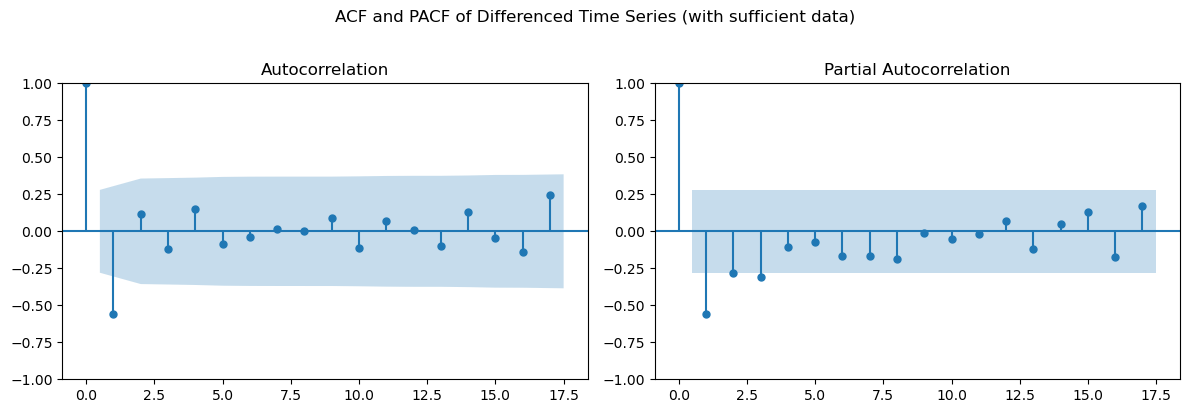

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np # Import numpy for creating longer series

# --- Your original code (with corrected date format from previous issue) ---
# Assuming 'data' DataFrame is already loaded and contains 'Date' and 'Demand' columns
# Let's create a *very small* sample DataFrame to reproduce the error:
# This DataFrame only has 5 data points
data_small = pd.DataFrame({
    'Date': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05'],
    'Demand': [10, 12, 15, 13, 16]
})

data_small['Date'] = pd.to_datetime(data_small['Date'], format='%Y-%m-%d')
time_series_small = data_small.set_index('Date')['Demand']

differenced_series_small = time_series_small.diff().dropna()
print(f"Number of observations in differenced_series_small: {len(differenced_series_small)}")
# For data_small: len(differenced_series_small) will be 4.
# 4 // 2 - 1 = 2 - 1 = 1.
# The default nlags calculation will try to be larger than 1, causing the error.


# --- How to fix: Use more data! ---
# Create a larger sample DataFrame (e.g., 50 data points)
dates = pd.date_range(start='2023-01-01', periods=50, freq='D')
demand = np.random.randint(50, 100, size=50) + np.arange(50) * 0.5 # Adding a trend for illustration
data_larger = pd.DataFrame({
    'Date': dates,
    'Demand': demand
})

data_larger['Date'] = pd.to_datetime(data_larger['Date'], format='%Y-%m-%d') # Format should be correct now
time_series_larger = data_larger.set_index('Date')['Demand']

differenced_series_larger = time_series_larger.diff().dropna()
print(f"Number of observations in differenced_series_larger: {len(differenced_series_larger)}")
# For data_larger: len(differenced_series_larger) will be 49.
# 49 // 2 - 1 = 24 - 1 = 23. Default nlags will be fine.


# Plot ACF and PACF of differenced time series with sufficient data
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series_larger, ax=axes[0])
plot_pacf(differenced_series_larger, ax=axes[1])
plt.suptitle('ACF and PACF of Differenced Time Series (with sufficient data)', y=1.02)
plt.tight_layout()
plt.show()

2023-03-02    74
2023-03-03    74
2023-03-04    74
2023-03-05    74
2023-03-06    74
2023-03-07    74
2023-03-08    74
2023-03-09    74
2023-03-10    74
2023-03-11    74
Freq: D, Name: predicted_mean, dtype: int32


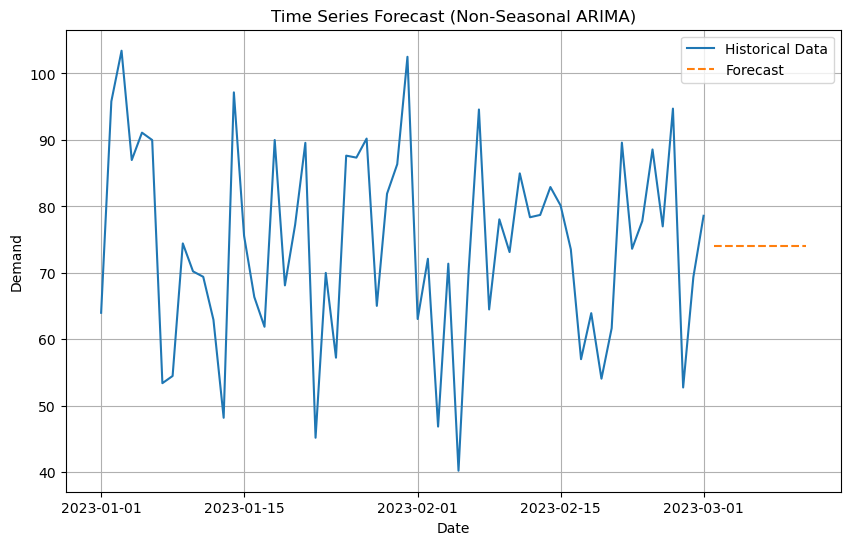

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming 'time_series' is already created and represents your 2 months of data
# For demonstration, let's create a time_series that spans exactly 2 months
dates = pd.date_range(start='2023-01-01', periods=60, freq='D') # 60 days for 2 months
demand = np.random.randint(50, 100, size=60) + np.sin(np.arange(60) * 0.5) * 10
time_series = pd.Series(demand, index=dates, name='Demand')

# 1. Remove the seasonal_order component
order = (1, 1, 1) # Non-seasonal ARIMA (p, d, q)
# seasonal_order is removed or set to (0, 0, 0, 0)
# model = SARIMAX(time_series, order=order, seasonal_order=(0, 0, 0, 0)) # or simply omit seasonal_order

model = SARIMAX(time_series, order=order) # This is equivalent to seasonal_order=(0,0,0,0)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

# Optional: Plotting for visualization
plt.figure(figsize=(10, 6))
plt.plot(time_series.index, time_series, label='Historical Data')
forecast_index = pd.date_range(start=time_series.index[-1], periods=future_steps + 1, freq='D')[1:]
plt.plot(forecast_index, predictions, label='Forecast', linestyle='--')
plt.title('Time Series Forecast (Non-Seasonal ARIMA)')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory) 
lead_time = 1 # it's different for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it's different for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it's different for every business, 0.1 is an example
stockout_cost = 10  # # it's different for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 148
Reorder Point: 148.0
Safety Stock: 74.0
Total Cost: 557.4
